# Task 5

## 5.1 Digit Classification

### 5.1.1 Load of Data

In [32]:
from tensorflow.keras.datasets import mnist

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

### 5.1.2 Split of test data into val and test set

In [33]:
from sklearn.model_selection import train_test_split

# Split the test data into validation and out-of-sample test sets
val_images, test_images, val_labels, test_labels = train_test_split(test_images, test_labels, test_size=0.3, random_state=42)
val_images.shape, test_images.shape,train_images.shape


((7000, 28, 28), (3000, 28, 28), (60000, 28, 28))

### 5.1.3 Distribution of digits over training and validation sets 

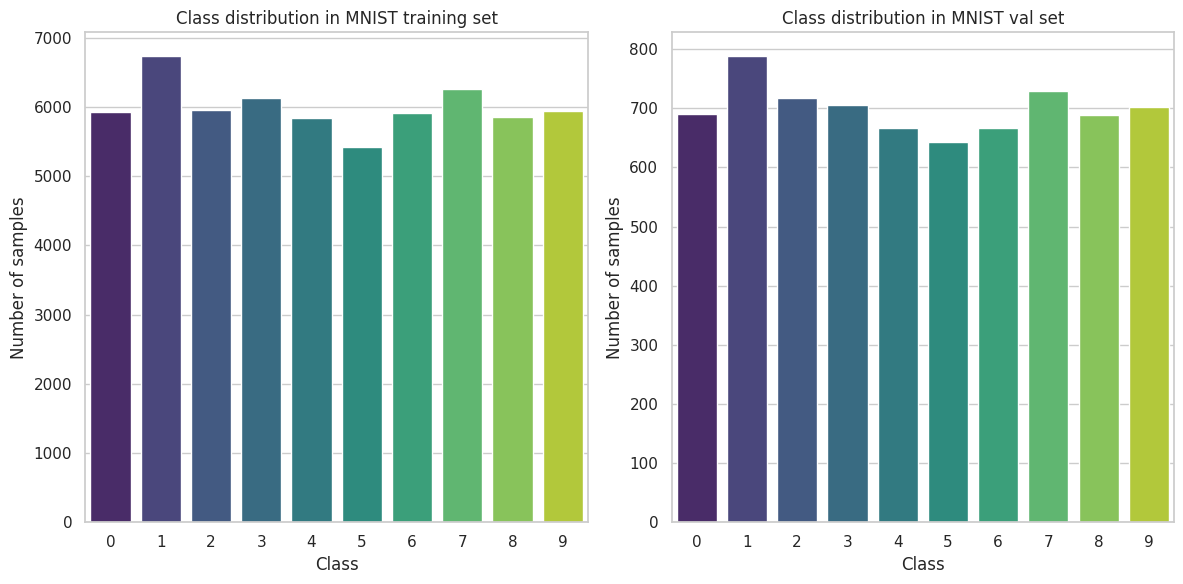

In [34]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Check class distribution in training set
unique_train, counts_train = np.unique(train_labels, return_counts=True)

# Create a bar plot for training set
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.barplot(x=unique_train, y=counts_train, palette="viridis")
plt.xlabel('Class')
plt.ylabel('Number of samples')
plt.title('Class distribution in MNIST training set')

# Check class distribution in test set
unique_test, counts_test = np.unique(val_labels, return_counts=True)

# Create a bar plot for test set
plt.subplot(1, 2, 2)
sns.barplot(x=unique_test, y=counts_test, palette="viridis")
plt.xlabel('Class')
plt.ylabel('Number of samples')
plt.title('Class distribution in MNIST val set')

plt.tight_layout()
plt.show()

The plots show that there is no issue of class imbalance over both train and val set. 

### 5.1.4 Model Architecture of Digit Classification

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras import metrics

# Define the encoder model
encoder_m = Sequential()

# Add a Convolutional layer with 32 filters of size 3x3, 'relu' activation function and appropriate input shape
encoder_m.add(Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))

# Add a MaxPooling layer to downsample the image
encoder_m.add(MaxPooling2D((2, 2)))

# Add another Convolutional layer with 64 filters of size 3x3 and 'relu' activation function
encoder_m.add(Conv2D(64, (3, 3), activation='relu'))

# Add another MaxPooling layer
encoder_m.add(MaxPooling2D((2, 2)))

# Flatten the tensor output from the previous layer
encoder_m.add(Flatten())

# Add a Dense layer to learn features
encoder_m.add(Dense(64, activation='relu'))

# Add a final Dense layer for classification
encoder_m.add(Dense(10, activation='softmax'))

def custom_recall(y_true, y_pred):
    # Convert y_true to one-hot encoding
    y_true_one_hot = tf.one_hot(tf.cast(y_true, tf.int32), depth=tf.shape(y_pred)[1])

    # Calculate true positives
    true_positives = K.sum(K.round(K.clip(y_true_one_hot * y_pred, 0, 1)), axis=0)

    # Calculate possible positives
    possible_positives = K.sum(K.round(K.clip(y_true_one_hot, 0, 1)), axis=0)

    # Calculate recall
    recall = K.mean(true_positives / (possible_positives + K.epsilon()))

    return recall

def custom_precision(y_true, y_pred):
    # Convert y_true to one-hot encoding
    y_true_one_hot = tf.one_hot(tf.cast(y_true, tf.int32), depth=tf.shape(y_pred)[1])

    # Calculate true positives
    true_positives = K.sum(K.round(K.clip(y_true_one_hot * y_pred, 0, 1)), axis=0)

    # Calculate predicted positives
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)), axis=0)

    # Calculate precision
    precision = K.mean(true_positives / (predicted_positives + K.epsilon()))

    return precision

# Compile the model
# Compile the model
encoder_m.compile(optimizer='adam', 
                loss='sparse_categorical_crossentropy', 
                metrics=['accuracy', custom_recall, custom_precision])

In [36]:
encoder_m.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 121,930 (476.29 KB)

 Trainable params: 121,930 (476.29 KB)

 Non-trainable params: 0 (0.00 B)

### 5.1.5 Model Training Setup 

In [37]:
from tensorflow.keras.callbacks import EarlyStopping

# Define the early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# Fit the model with the early stopping callback
history = encoder_m.fit(train_images, train_labels, epochs=20, validation_data=(val_images, val_labels), callbacks=[early_stopping])

Epoch 1/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 36s 18ms/step - accuracy: 0.8790 - custom_precision: 0.8517 - custom_recall: 0.8345 - loss: 1.2219 - val_accuracy: 0.9806 - val_custom_precision: 0.9477 - val_custom_recall: 0.9441 - val_loss: 0.0614
Epoch 2/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 33s 18ms/step - accuracy: 0.9797 - custom_precision: 0.9497 - custom_recall: 0.9461 - loss: 0.0650 - val_accuracy: 0.9806 - val_custom_precision: 0.9468 - val_custom_recall: 0.9420 - val_loss: 0.0576
Epoch 3/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 41s 18ms/step - accuracy: 0.9854 - custom_precision: 0.9491 - custom_recall: 0.9470 - loss: 0.0470 - val_accuracy: 0.9849 - val_custom_precision: 0.9484 - val_custom_recall: 0.9454 - val_loss: 0.0448
Epoch 4/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 41s 18ms/step - accuracy: 0.9875 - custom_precision: 0.9522 - custom_recall: 0.9509 - loss: 0.0392 - val_accuracy: 0.9856 - val_custom_precision: 0.9502 - val_custom_recall: 0.9491 - val_loss: 0.0520
Epoch 5/20
1875/1875 ━━━━━━━━━━━

Despite setting epochs = 20, when the model fails to improve val_loss in there consecutive epochs, the training stops at epochs = 7. 

### 5.1.6 Visualizing the different metrics of accurcy and loss

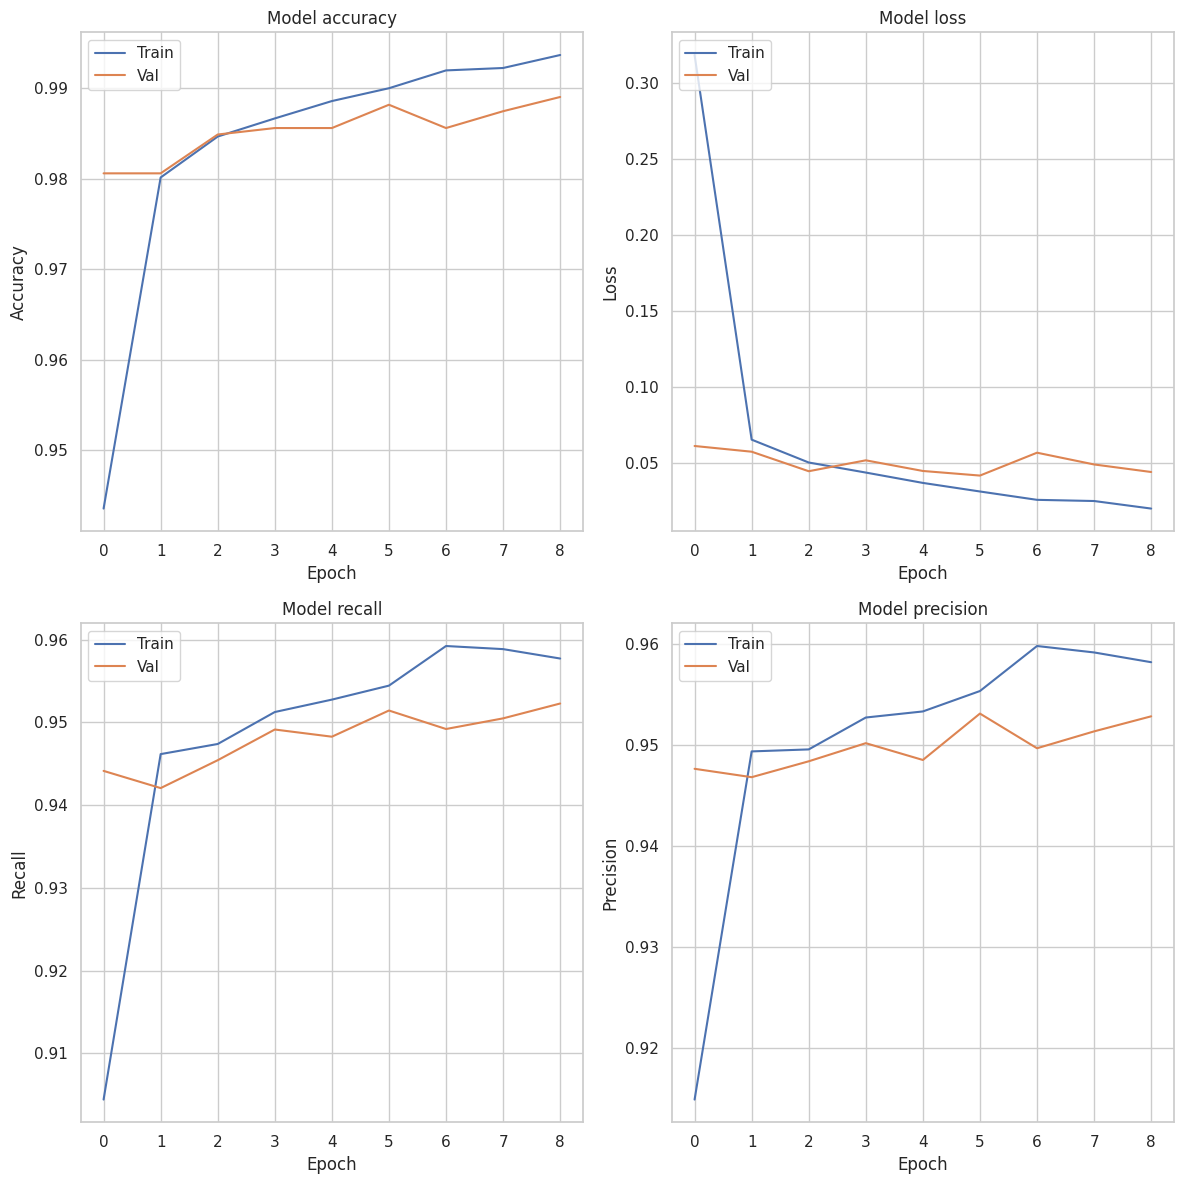

In [38]:
import matplotlib.pyplot as plt

# Create a new figure
plt.figure(figsize=(12, 12))

# Subplot for accuracy
plt.subplot(2, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

# Subplot for loss
plt.subplot(2, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

# Subplot for recall
plt.subplot(2, 2, 3)
plt.plot(history.history['custom_recall'])
plt.plot(history.history['val_custom_recall'])
plt.title('Model recall')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

# Subplot for precision
plt.subplot(2, 2, 4)
plt.plot(history.history['custom_precision'])
plt.plot(history.history['val_custom_precision'])
plt.title('Model precision')
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

# Adjust the layout
plt.tight_layout()

# Display the figure
plt.show()

The good scores along with small differnces between train and val scores acorss all metrics indicate that the model is perfroming well during training. The precision and recall scores are also goods. So, there is no issue of class imbalace bias as well. The training stops before the train score and var score move opposite direction of each other. Generally, if the train score keeps on increasing and val socre begins to decline, it is sign of overfitting. The early stops of trainign seems to prevent this sitaution. Despite these, the model accuracy is pretty high and there is still chance of overfitting. Therefore, unless the model is not going to test on the unseen data, we can not say anything from this point. 

### 5.1.7 Model evaluation on unseen data 

In [39]:
# Evaluate the model on the test set
evaluation_metrics_m = encoder_m.evaluate(test_images, test_labels)

# Print all evaluation metrics
loss = evaluation_metrics_m[0] 
accuracy = evaluation_metrics_m[1] 
precision = evaluation_metrics_m[2]  
recall = evaluation_metrics_m[3]

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9872 - custom_precision: 0.9482 - custom_recall: 0.9497 - loss: 0.0553


In [40]:
# Create a dictionary with your data
import pandas as pd 
data_m = {
    'Loss': [evaluation_metrics_m[0]],
    'Accuracy': [evaluation_metrics_m[1]],
    'Precision': [evaluation_metrics_m[2]],
    'Recall': [evaluation_metrics_m[3]]
}

# Create a DataFrame from the dictionary
df_m = pd.DataFrame(data_m,index = ['score']).T

# Print the DataFrame
print(df_m)

              score
Loss       0.062250
Accuracy   0.984333
Precision  0.947452
Recall     0.946674


The accuracy of model on the unseen test set is still high. Therefore, I think the model is good for prediction. However, there are a lot of rooms to improve this model. I have not hypertuned the model here and tested the model in the different set ups. The training, validating and testing model is iterative process and needs more time and resooruces. 

# 5.2 Odd-Even Classification

This becomes binary clssification problem as we have two classes here. 
First class: odd = 1
second class: even = 0

### 5.2.1 Data Preperation 

In [41]:
# Assuming train_labels and test_labels are original labels
train_labels_odd_even = train_labels % 2
test_labels_odd_even = test_labels % 2

In [42]:
# Split the test data into validation and out-of-sample test sets
val_images, test_images, val_labels, test_labels = train_test_split(test_images, test_labels_odd_even, test_size=0.3, random_state=42)

### 5.2.2 Distribution of classes over test and val set 

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


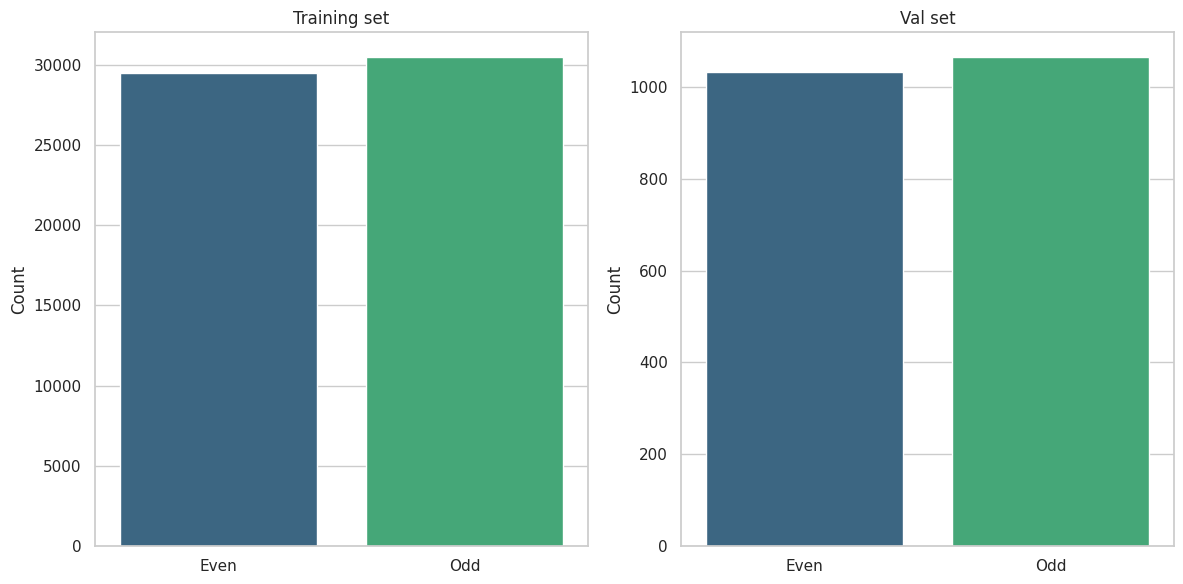

In [43]:

# Set the style of seaborn
sns.set(style="whitegrid")

# Calculate the counts of odd and even labels in the training set
train_counts = [len(train_labels_odd_even) - np.count_nonzero(train_labels_odd_even), np.count_nonzero(train_labels_odd_even)]

# Calculate the counts of odd and even labels in the testing set
val_counts = [len(val_labels) - np.count_nonzero(val_labels), np.count_nonzero(val_labels)]

# Create a new figure
plt.figure(figsize=(12, 6))

# Subplot for the training set
plt.subplot(1, 2, 1)
sns.barplot(x=['Even', 'Odd'], y=train_counts, palette="viridis")
plt.title('Training set')
plt.ylabel('Count')

# Subplot for the testing set
plt.subplot(1, 2, 2)
sns.barplot(x=['Even', 'Odd'], y=val_counts, palette="viridis")
plt.title('Val set')
plt.ylabel('Count')

# Adjust the layout
plt.tight_layout()

# Display the figure
plt.show()

### 5.2.3 Model architecture for binary classification

In [44]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras import metrics

# Define the encoder model
encoder = Sequential()

# Add a Convolutional layer with 32 filters of size 3x3, 'relu' activation function and appropriate input shape
encoder.add(Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)))

# Add a MaxPooling layer to downsample the image
encoder.add(MaxPooling2D((2, 2)))

# Add another Convolutional layer with 64 filters of size 3x3 and 'relu' activation function
encoder.add(Conv2D(64, (3, 3), activation='relu'))

# Add another MaxPooling layer
encoder.add(MaxPooling2D((2, 2)))

# Flatten the tensor output from the previous layer
encoder.add(Flatten())

# Add a Dense layer to learn features
encoder.add(Dense(64, activation='relu'))

# Add a final Dense layer for classification
encoder.add(Dense(1, activation='sigmoid'))  # Changed to 1 unit with 'sigmoid' activation

# Compile the model
encoder.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy',metrics.Precision(), metrics.Recall()])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


### 5.2.4 Training set up 

In [45]:
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3)

# Fit the model with early stopping callback
history = encoder.fit(train_images, train_labels_odd_even, 
                      validation_data= (val_images,val_labels),
                      epochs=20, 
                      callbacks=[early_stopping])

Epoch 1/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 34s 17ms/step - accuracy: 0.9367 - loss: 0.6805 - precision_1: 0.9391 - recall_1: 0.9360 - val_accuracy: 0.9810 - val_loss: 0.0539 - val_precision_1: 0.9707 - val_recall_1: 0.9925
Epoch 2/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 41s 17ms/step - accuracy: 0.9869 - loss: 0.0389 - precision_1: 0.9883 - recall_1: 0.9860 - val_accuracy: 0.9876 - val_loss: 0.0316 - val_precision_1: 0.9860 - val_recall_1: 0.9897
Epoch 3/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 41s 17ms/step - accuracy: 0.9913 - loss: 0.0246 - precision_1: 0.9920 - recall_1: 0.9909 - val_accuracy: 0.9881 - val_loss: 0.0343 - val_precision_1: 0.9780 - val_recall_1: 0.9991
Epoch 4/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 32s 17ms/step - accuracy: 0.9930 - loss: 0.0223 - precision_1: 0.9935 - recall_1: 0.9928 - val_accuracy: 0.9957 - val_loss: 0.0207 - val_precision_1: 0.9944 - val_recall_1: 0.9972
Epoch 5/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 33s 17ms/step - accuracy: 0.9945 - loss: 0.0178 - precision_1: 0.9949 

As in our previous case, the training stops before its last epoch

In [46]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'precision_1', 'recall_1', 'val_accuracy', 'val_loss', 'val_precision_1', 'val_recall_1'])

### 5.2.5 Visualizing the different metrics of accurcy and loss

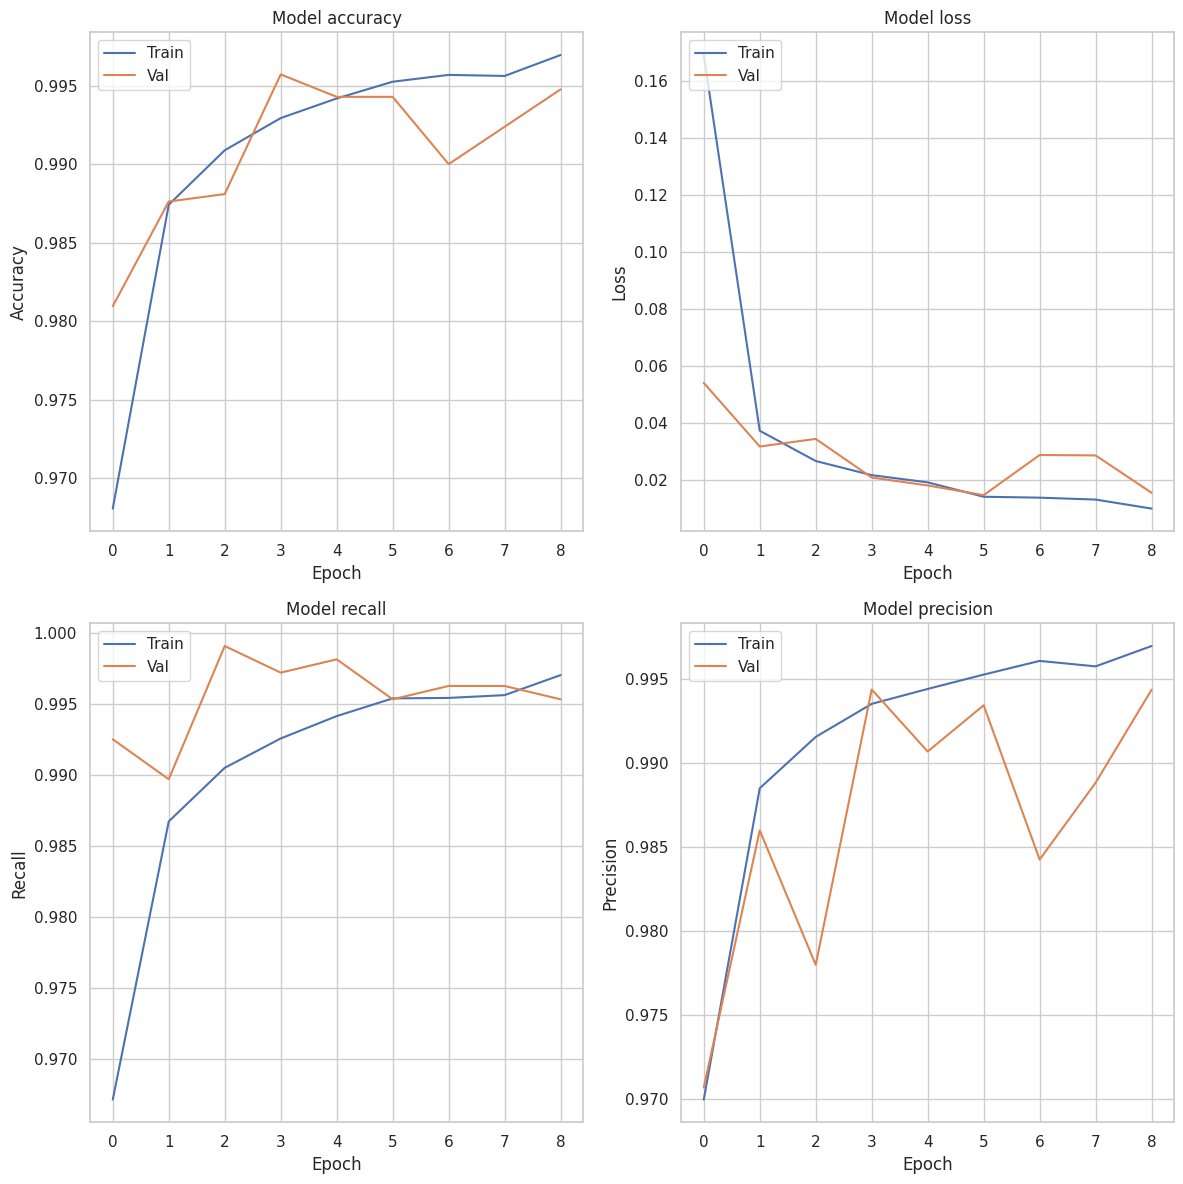

In [48]:
# Create a new figure
plt.figure(figsize=(12, 12))

# Subplot for accuracy
plt.subplot(2, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

# Subplot for loss
plt.subplot(2, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

# Subplot for recall
plt.subplot(2, 2, 3)
plt.plot(history.history['recall_1'])
plt.plot(history.history['val_recall_1'])
plt.title('Model recall')
plt.ylabel('Recall')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

# Subplot for precision
plt.subplot(2, 2, 4)
plt.plot(history.history['precision_1'])
plt.plot(history.history['val_precision_1'])
plt.title('Model precision')
plt.ylabel('Precision')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')

# Adjust the layout
plt.tight_layout()

# Display the figure
plt.show()

Like in our digit classification setup, here as well, model is performing good both in train and val set and metrics over these sets are also close to each other.

### 5.2.6 Model Evaluation on unseen data 

In [49]:
# Evaluate the model on the test set
evaluation_metrics = encoder.evaluate(test_images, test_labels)

# Print all evaluation metrics
loss = evaluation_metrics[0]  
accuracy = evaluation_metrics[1]  
precision = evaluation_metrics[2]  
recall = evaluation_metrics[3]


29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9957 - loss: 0.0205 - precision_1: 1.0000 - recall_1: 0.9908


In [50]:
# Create a dictionary with your data
data = {
    'Loss': [evaluation_metrics[0]],
    'Accuracy': [evaluation_metrics[1]],
    'Precision': [evaluation_metrics[2]],
    'Recall': [evaluation_metrics[3]]
}

# Create a DataFrame from the dictionary
df = pd.DataFrame(data, index = ['score']).T

# Print the DataFrame
print(df)

              score
Loss       0.021893
Accuracy   0.995556
Precision  1.000000
Recall     0.990826


The model has already performed well in trainng and validation stage. Here in out of sample test as well, the model has performed well accross all metrics. This indicates that the model is good for prediction. 

In [1]:
!jupyter nbconvert --to html task5.ipynb

[NbConvertApp] Converting notebook task5.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 4 image(s).
[NbConvertApp] Writing 768515 bytes to task5.html
